# 新段落

# Profoilo Optimization through Quadratic Programming


In [1]:
!pip install pulp
!pip install mosek
import pulp
import numpy as np
import cvxpy as cp
!pip install tushare
import tushare as ts
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import itertools
import matplotlib.pyplot as plt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.7/17.7 MB 23.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.7/15.7 MB 30.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.1/142.1 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.9/137.9 kB 7.4 MB/s eta 0:00:00


In [61]:
def load_stock_data(stock_codes, start, end, market='CHINA'):
    ts.set_token('28b2dbb3562598167a7ae7929457748793ba2c1fb2f47d4542ac6b8b')
    pro = ts.pro_api()
    Full_CHINA_STOCK_df = pd.DataFrame()
    for code in stock_codes:
        df = pro.daily(ts_code=code, start_date=start, end_date=end)
        adj_factors = pro.adj_factor(ts_code=code, start_date=start, end_date=end)
        daily_basic = pro.daily_basic(ts_code=code, start_date=start, end_date=end)
        daily_basic = daily_basic.drop(columns=['close'])

        df = pd.merge(df, adj_factors[['trade_date', 'adj_factor']], on='trade_date', how='left')
        df['close_adj'] = df['close'] / df['adj_factor']
        df['open_adj'] = df['open'] / df['adj_factor']
        df['high_adj'] = df['high'] / df['adj_factor']
        df['low_adj'] = df['low'] / df['adj_factor']
        df['close_price'] = df['close']
        df['change'] = df['change']
        df['pct_change'] = df['pct_chg']

        df = pd.merge(df, daily_basic, on='trade_date', how='left')
        df = df.drop(columns=['adj_factor', 'ts_code_x','ts_code_y','close'])

        df_renamed = df.rename(columns=lambda x: f"{x}_{code.split('.')[0]}" if x != 'trade_date' else x)

        if Full_CHINA_STOCK_df.empty:
            Full_CHINA_STOCK_df = df_renamed
        else:
            Full_CHINA_STOCK_df = pd.merge(Full_CHINA_STOCK_df, df_renamed, on='trade_date', how='outer')

    Full_CHINA_STOCK_df.sort_values('trade_date', inplace=True)
    # Identify columns to normalize (exclude trade_date)
    #columns_to_normalize = [col for col in Full_CHINA_STOCK_df.columns if col != 'trade_date']

    # Normalize using MinMaxScaler
    #scaler = MinMaxScaler()
    #Full_CHINA_STOCK_df[columns_to_normalize] = scaler.fit_transform(Full_CHINA_STOCK_df[columns_to_normalize])

    return Full_CHINA_STOCK_df

def load_trading_days(start, end, market):
    if market == 'CHINA':
        ts.set_token('28b2dbb3562598167a7ae7929457748793ba2c1fb2f47d4542ac6b8b')
        pro = ts.pro_api()
        trade_cal = pro.trade_cal(exchange = '',start_date = start, end_date = end)
        trade_cal = trade_cal[trade_cal['is_open'] == 1]
        trading_dates = trade_cal['cal_date'].tolist()
        return trading_dates
    elif market == 'US':
        raise ValueError('Not support yet')
    else:
        raise ValueError('Invalid market type')

def calculate_expected_returns(stock_data, stock_codes):
    # Identify close and pre_close price columns for the stocks
    close_columns = [f'close_price_{code.split(".")[0]}' for code in stock_codes]
    pre_close_columns = [f'pre_close_{code.split(".")[0]}' for code in stock_codes]

    # Check if the required columns exist in the stock_data
    missing_columns = [col for col in close_columns + pre_close_columns if col not in stock_data.columns]
    if missing_columns:
        raise ValueError(f"The following columns are missing: {missing_columns}")

    # Filter the close and pre_close price columns
    price_columns = ['trade_date'] + close_columns + pre_close_columns
    prices_df = stock_data[price_columns]

    # Calculate percentage changes (returns) using pre_close and close
    returns_df = prices_df.set_index('trade_date')  # Set trade_date as index
    for code in stock_codes:
        close_col = f'close_price_{code.split(".")[0]}'
        pre_close_col = f'pre_close_{code.split(".")[0]}'
        return_col = f'return_{code.split(".")[0]}'
        returns_df[return_col] = (returns_df[close_col] - returns_df[pre_close_col]) / returns_df[pre_close_col]

    # Keep only the trade_date and returns columns
    return_columns = [f'return_{code.split(".")[0]}' for code in stock_codes]
    returns_df = returns_df[return_columns]

    # Reset index and clean up infinite or NaN values
    returns_df = returns_df.replace([float('inf'), float('-inf')], 0)
    returns_df = returns_df.fillna(0)

    return returns_df



start = '20210101'
mid = '20240606'
end = '20240829'
expected_returns = []
stock_codes = ['601318.SH', '601398.SH', '600519.SH', '000001.SZ', '601857.SH']
close_columns = [f'close_price_{code.split(".")[0]}' for code in stock_codes]

trading_days = load_trading_days(start, mid, market='CHINA')
test_trading_days = load_trading_days(mid, end, market='CHINA')
# Step 1: Load the stock database
df = load_stock_data(stock_codes, start=start, end=end, market='CHINA')
filtered_Full_CHINA_STOCK_df = df[df['trade_date'].isin(trading_days)]
test_filtered_Full_CHINA_STOCK_df = df[df['trade_date'].isin(test_trading_days)]

# Split the data into n-365, 365 days
history_df = filtered_Full_CHINA_STOCK_df
test_df = test_filtered_Full_CHINA_STOCK_df
display(test_df)

# Construct the open price matrix
open_columns = [f'open_{code.split(".")[0]}' for code in stock_codes]
open_df = test_df[open_columns]
open_df = test_df[['trade_date'] + open_columns]
open_df.set_index('trade_date', inplace=True)

close_df = test_df[close_columns]
close_df = test_df[['trade_date'] + close_columns]
close_df.set_index('trade_date', inplace=True)
print("Close Price Matrix:")
print(close_df)

# Step 2: Construct the returns matrix
returns_df = history_df[close_columns].pct_change()
returns_df = returns_df.replace([float('inf'), float('-inf')], pd.NA)
returns_df.dropna(inplace=True)

# Step 3: Get the expected Returns for each stocks
expected_returns_matrix = returns_df.mean()
print("\nExpected Returns:")
print(expected_returns_matrix)

# Step 4: Compute the covariance matrix
covariance_matrix = returns_df.cov()
print("\nCovariance Matrix:")
print(covariance_matrix)

# daily returns for test days
test_returns_df = calculate_expected_returns(test_df, stock_codes)
display(test_returns_df)

,trade_date,open_601318,high_601318,low_601318,pre_close_601318,change_601318,pct_chg_601318,vol_601318,amount_601318,close_adj_601318,...,pb_601857,ps_601857,ps_ttm_601857,dv_ratio_601857,dv_ttm_601857,total_share_601857,float_share_601857,free_share_601857,total_mv_601857,circ_mv_601857
828,20240606,43.20,43.33,42.37,43.08,-0.63,-1.4624,542620.89,2313057.245,14.927210,...,1.2260,0.6072,0.5916,4.3043,4.3043,1.830210e+07,1.619221e+07,1.099851e+06,1.828380e+08,1.617602e+08
829,20240607,42.60,42.78,42.00,42.45,-0.33,-0.7774,421393.79,1781350.640,14.811168,...,1.2260,0.6072,0.5916,4.3043,4.3043,1.830210e+07,1.619221e+07,1.099851e+06,1.828380e+08,1.617602e+08
830,20240611,41.91,42.19,41.60,42.12,-0.29,-0.6885,422362.79,1767535.003,14.709192,...,1.2051,0.5969,0.5815,4.3788,4.3788,1.830210e+07,1.619221e+07,1.099851e+06,1.797266e+08,1.590075e+08
831,20240612,41.83,41.90,41.36,41.83,-0.43,-1.0280,398340.17,1653283.609,14.557986,...,1.2272,0.6078,0.5922,4.3000,4.3000,1.830210e+07,1.619221e+07,1.099851e+06,1.830210e+08,1.619221e+08
832,20240613,41.58,41.66,41.19,41.40,-0.10,-0.2415,320428.01,1323757.554,14.522822,...,1.2162,0.6024,0.5868,4.3391,4.3391,1.830210e+07,1.619221e+07,1.099851e+06,1.813738e+08,1.604648e+08
833,20240614,41.19,42.19,41.16,41.30,0.57,1.3801,635624.38,2651178.962,14.723258,...,1.2063,0.5975,0.5821,4.3744,4.3744,1.830210e+07,1.619221e+07,1.099851e+06,1.799096e+08,1.591694e+08
834,20240617,41.60,41.83,41.38,41.87,-0.29,-0.6926,384727.47,1600335.663,14.621281,...,1.1842,0.5866,0.5714,4.4560,4.4560,1.830210e+07,1.619221e+07,1.099851e+06,1.766152e+08,1.562548e+08
835,20240618,41.70,42.05,41.57,41.58,0.15,0.3608,353452.19,1476476.518,14.674028,...,1.1977,0.5933,0.5780,4.4057,4.4057,1.830210e+07,1.619221e+07,1.099851e+06,1.786285e+08,1.580359e+08
836,20240619,41.74,42.19,41.61,41.73,0.27,0.6470,410639.57,1721419.835,14.768971,...,1.2137,0.6012,0.5856,4.3478,4.3478,1.830210e+07,1.619221e+07,1.099851e+06,1.810077e+08,1.601409e+08
837,20240620,41.99,42.07,41.51,42.00,-0.49,-1.1667,364789.92,1525392.591,14.596666,...,1.2346,0.6115,0.5957,4.2744,4.2744,1.830210e+07,1.619221e+07,1.099851e+06,1.841191e+08,1.628936e+08


Close Price Matrix:
            close_price_601318  close_price_601398  close_price_600519  \
trade_date                                                               
20240606                 42.45                5.46             1639.81   
20240607                 42.12                5.52             1619.18   
20240611                 41.83                5.44             1569.00   
20240612                 41.40                5.40             1571.68   
20240613                 41.30                5.43             1555.01   
20240614                 41.87                5.50             1555.00   
20240617                 41.58                5.43             1541.50   
20240618                 41.73                5.45             1521.50   
20240619                 42.00                5.50             1501.00   
20240620                 41.51                5.52             1500.10   
20240621                 41.67                5.51             1471.00   
20240624          

,return_601318,return_601398,return_600519,return_000001,return_601857
trade_date,,,,,
20240606,-0.014624,0.000000,-0.002549,0.002760,0.022518
20240607,-0.007774,0.010989,-0.012581,0.008257,0.000000
20240611,-0.006885,-0.014493,-0.030991,-0.010919,-0.017017
20240612,-0.010280,-0.007353,0.001708,0.000920,0.018330
20240613,-0.002415,0.005556,-0.010606,-0.007353,-0.009000
20240614,0.013801,0.012891,-0.000006,0.009921,-0.008073
20240617,-0.006926,-0.012727,-0.008682,-0.007859,-0.018311
20240618,0.003608,0.003683,-0.012974,-0.001980,0.011399
20240619,0.006470,0.009174,0.006964,0.006944,0.013320


In [22]:
returns_df = test_df[close_columns].pct_change()
returns_df = returns_df.replace([float('inf'), float('-inf')], pd.NA)
returns_df.dropna(inplace=True)
returns_df = returns_df.mean()

print("Returns Matrix (close price pct change):")
print(returns_df)

Returns Matrix (close price pct change):
close_price_601318    0.002236
close_price_601398    0.001036
close_price_600519   -0.000496
close_price_000001    0.000476
close_price_601857   -0.001710
dtype: float64


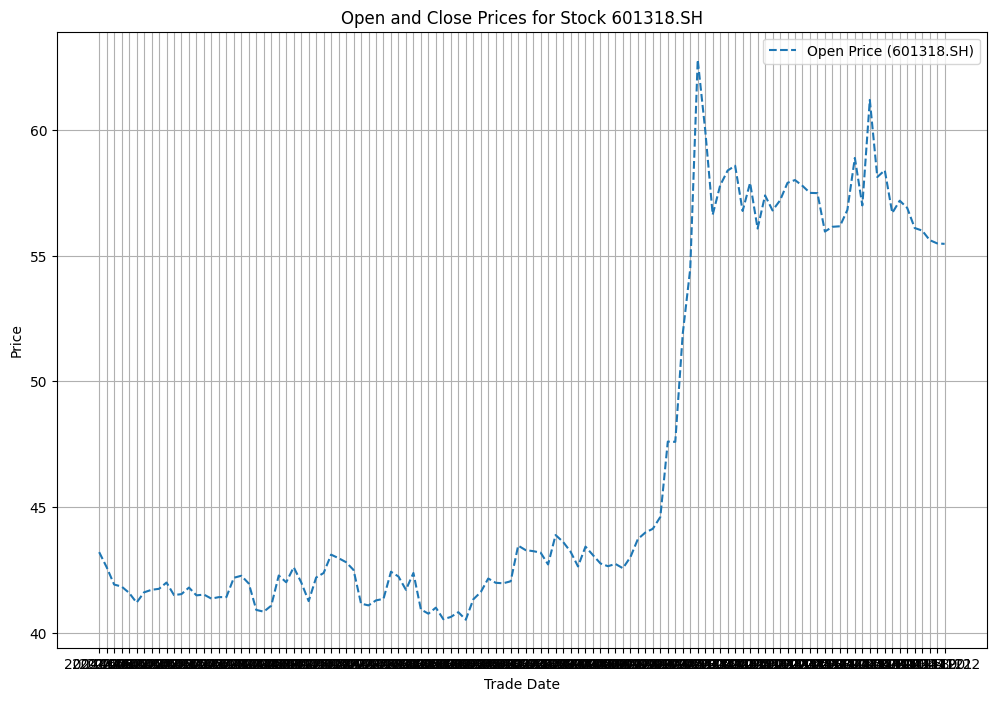

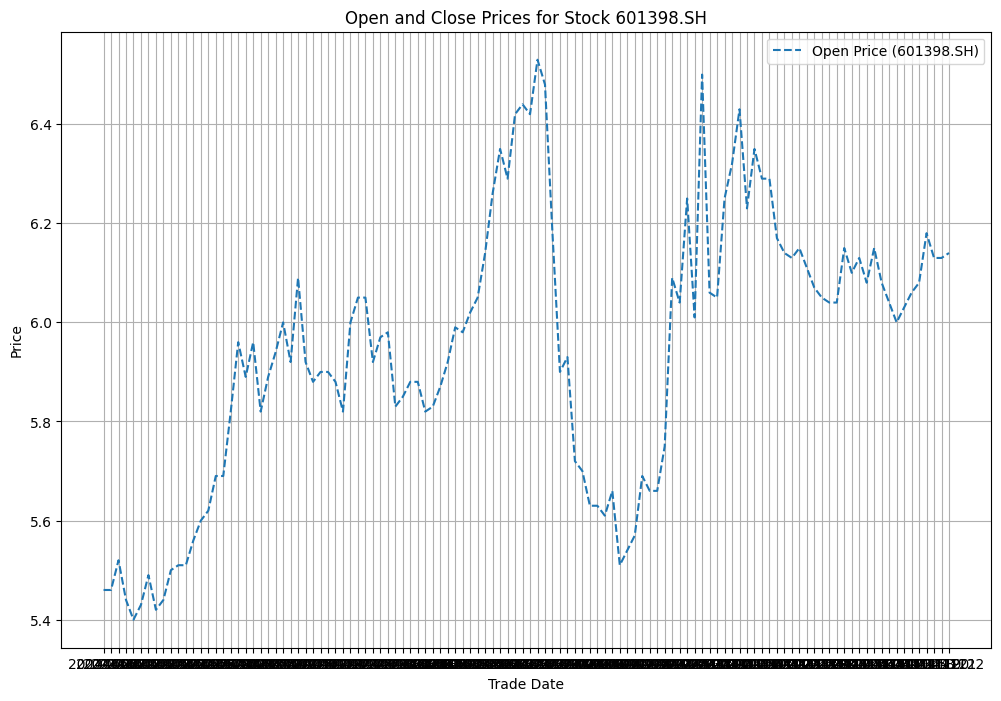

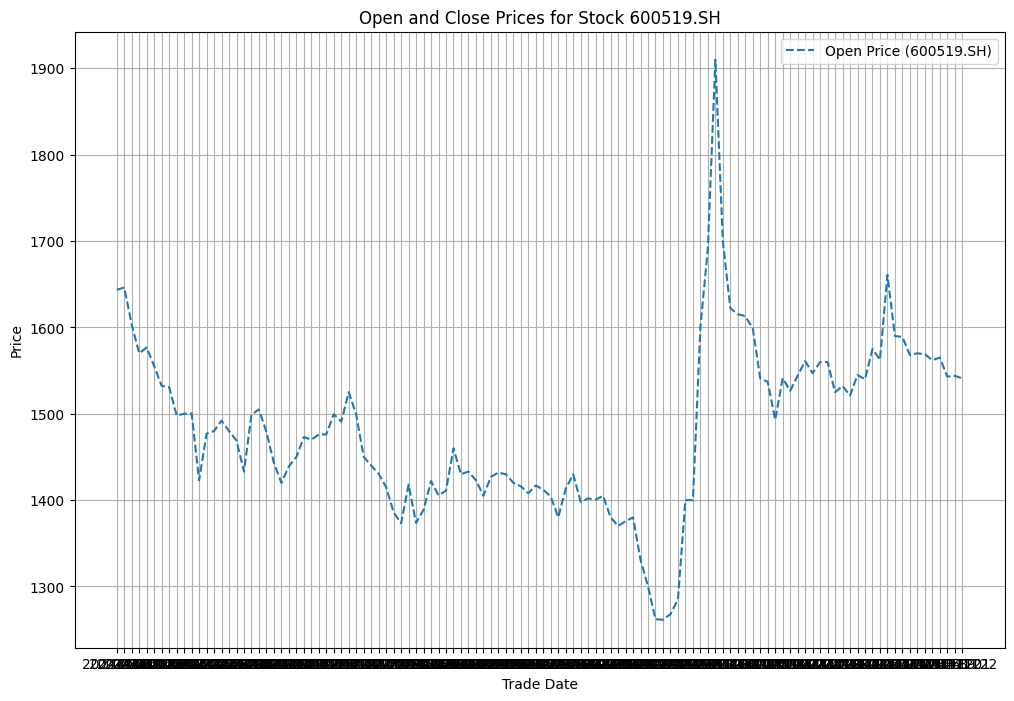

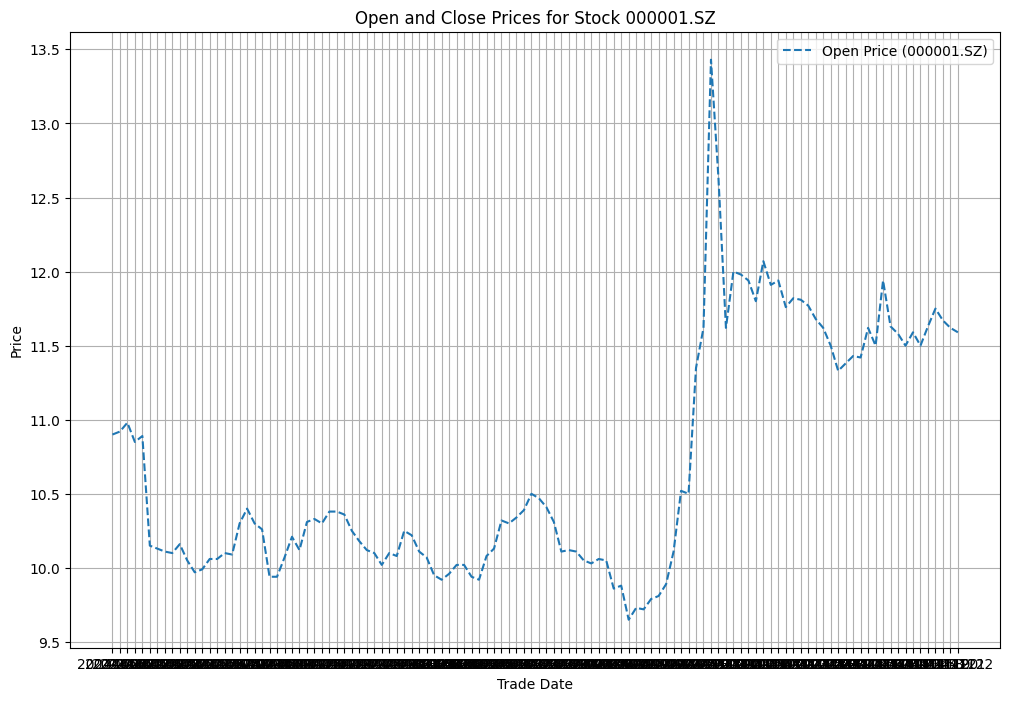

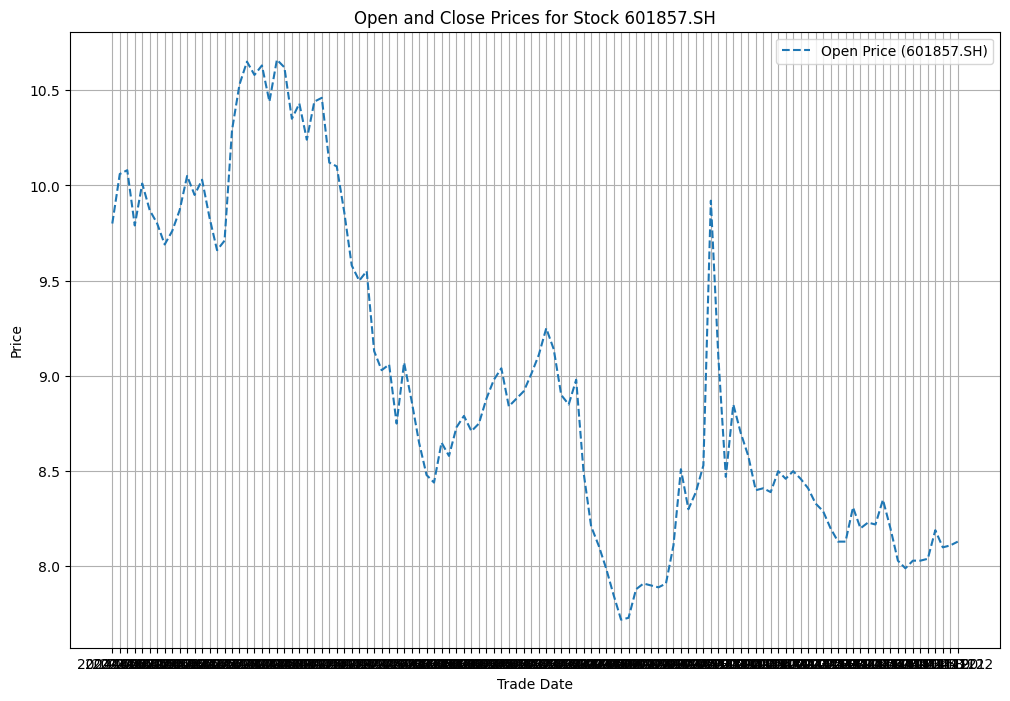

In [50]:
for stock in stock_codes:
    plt.figure(figsize=(12, 8))
    plt.plot(open_df.index, open_df[f'open_{stock.split(".")[0]}'], label=f'Open Price ({stock})', linestyle='--')
    #plt.plot(df.index, df[f'close_price_{stock}'], label=f'Close Price ({stock})')
    plt.title(f"Open and Close Prices for Stock {stock}")
    plt.xlabel("Trade Date")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(True)
    plt.show()

# Constructing the QP model using cvxpy

In [66]:
import numpy as np
import cvxpy as cp

# Problem setup
n_stocks = 5
T = len(test_returns_df)
prices = open_df.to_numpy()
returns = test_returns_df.to_numpy()
Q = covariance_matrix.to_numpy()
Q = 0.5 * (Q + Q.T)
Q += np.eye(n_stocks) * 1e-4
initial_cash = 10000
lambda_tradeoff = 0.8  # Tradeoff between return and risk
alpha = 0.7  # Smoothing factor for expected returns

# Decision variables
b = cp.Variable((T, n_stocks))  # Amounts bought
s = cp.Variable((T, n_stocks))  # Amounts sold
h = cp.Variable((T, n_stocks))  # Holdings
cash = cp.Variable(T)  # Cash balance

# Initial conditions
constraints = [
    h[0, :] == 0,
    cash[0] == initial_cash  # Initial cash
]

mu = expected_returns_matrix.to_numpy().flatten()

# Transaction and portfolio constraints
for t in range(T-1):
    if t == 0:
      recent_returns = np.array([0] * n_stocks)
    else:
      recent_returns = np.mean(returns[:t, :], axis=0)

    mu = alpha * recent_returns + (1 - alpha) * mu

    constraints += [
        h[t + 1, :] == h[t, :] + b[t, :] - s[t, :],  # Holding update
        cash[t + 1] == cash[t] - cp.sum(b[t, :] * prices[t, :]) + cp.sum(s[t, :] * prices[t, :]),  # Cash update including transaction costs
        #cp.sum(b[t, :] * prices[t, :]) <= cash[t],  # Money spent on buying must not exceed current cash
        s[t, :] <= h[t, :] + b[t, :],  # No short-selling
        b[t, :] >= 0,  # No short-selling
        s[t, :] >= 0,  # No short-selling
        h[t, :] >= 0,  # Strict non-negativity for holdings
        cash[t] >= 0,  # No negative cash
    ]

# Objective: Risk-Return Tradeoff
expected_returns = cp.sum([h[t, :] @ mu for t in range(T)])   # Total expected returns
portfolio_variance = cp.sum([cp.quad_form(h[t, :], Q) for t in range(T)])  # Total variance
objective = cp.Maximize(
    lambda_tradeoff * expected_returns - (1 - lambda_tradeoff) * portfolio_variance
)

# Solve the problem
problem = cp.Problem(objective, constraints)
problem.solve(solver=cp.SCS, verbose=True, eps_abs=1e-6, eps_rel=1e-6, max_iters = 500000)

# Output results
if problem.status == cp.OPTIMAL:
    print("Optimal portfolio found:")

    for t in range(T):
        print(f"Day {t + 1} Holdings:")
        print(h.value[t])
        print(f"        buy:")
        print(b.value[t])
        print(f"        sell:")
        print(s.value[t])

    print("Holdings over time:", h.value)
    print("Cash over time:", cash.value)
    print("Final Portfolio Value:", cash.value[-1] + np.sum(h.value[-1, :] * prices[-1, :]))
else:
    print("Problem could not be solved.")


                                     CVXPY                                     
                                     v1.5.4                                    
(CVXPY) Nov 26 04:03:45 AM: Your problem has 960 variables, 1599 constraints, and 0 parameters.


/usr/local/lib/python3.10/dist-packages/cvxpy/expressions/expression.py:650: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 3899 times so far.

  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/dist-packages/cvxpy/expressions/expression.py:650: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 3900 times so far.

  warnings.warn(msg, UserWarning)
/usr/local/lib/pytho

(CVXPY) Nov 26 04:03:45 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Nov 26 04:03:45 AM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Nov 26 04:03:45 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Nov 26 04:03:45 AM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Nov 26 04:03:45 AM: Compiling problem (target solver=SCS).
(CVXPY) Nov 26 04:03:45 AM: Reduction chain: FlipObjective -> Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> SCS
(CVXPY) Nov 26 04:03:45 AM: Applying reduction FlipObjective
(CVXPY) Nov 26 04:03:45 AM: Applying reduction Dcp2Cone
(CVXPY) Nov 26 04:03:4

In [67]:
def calculate_daily_net_price(close_price_df, holdings_data, cash_data):
    daily_net_values = []
    for day_index, holding in enumerate(holdings_data):
        net_price = np.sum(holding * close_price_df.iloc[day_index].values) + cash_data[day_index]
        daily_net_values.append(net_price)

    return daily_net_values

daily_net_values = calculate_daily_net_price(close_df, h.value, cash.value)
print(daily_net_values)

[9999.477123723878, 10001.247533160538, 9996.769420208082, 9994.460205662697, 9995.047769672443, 9997.234982948368, 9993.634826646194, 9993.816453107876, 9995.178481287823, 9995.42354049833, 9994.411071088218, 9996.168409919348, 9996.107997192428, 9996.880204558105, 9999.261667934783, 9998.67374716551, 10003.109397609094, 10009.04602932897, 10004.651367328437, 10007.056333329796, 10000.941888128944, 10002.796276019235, 10004.546127550879, 10006.571917986501, 10003.258382499997, 10009.097040813012, 10013.69904378015, 10000.358369070342, 10000.85736083908, 10000.430007636192, 10000.129769926692, 9996.734195271183, 10003.159380502799, 10004.764309861786, 10004.45299416901, 9998.70994247623, 10000.439147781488, 10000.52527259909, 9994.56624938591, 9995.466600573405, 9995.139283449533, 9994.565715380626, 9991.421019571979, 9992.076918974903, 9994.028467873091, 9995.933732500815, 9998.631859705858, 9998.856548499105, 9999.521589104603, 10000.70941, 10004.359609294495, 10009.676629733993, 100

In [70]:
def save_daily_returns_to_csv(daily_returns, filename='eval_net_prices_QP.csv'):
    # Prepare data for saving
    data = []
    for index, day_data in enumerate(daily_returns, start=1):
        data.append({
            'Model Type': 'Quadratic Programming',
            'Days': index,
            'Daily Net Values': day_data
        })

    # Create DataFrame and save to CSV
    df = pd.DataFrame(data)
    df.to_csv(filename, index=False)

    print(f"Data saved to {filename}")

save_daily_returns_to_csv(daily_net_values)

Data saved to eval_net_prices_QP.csv


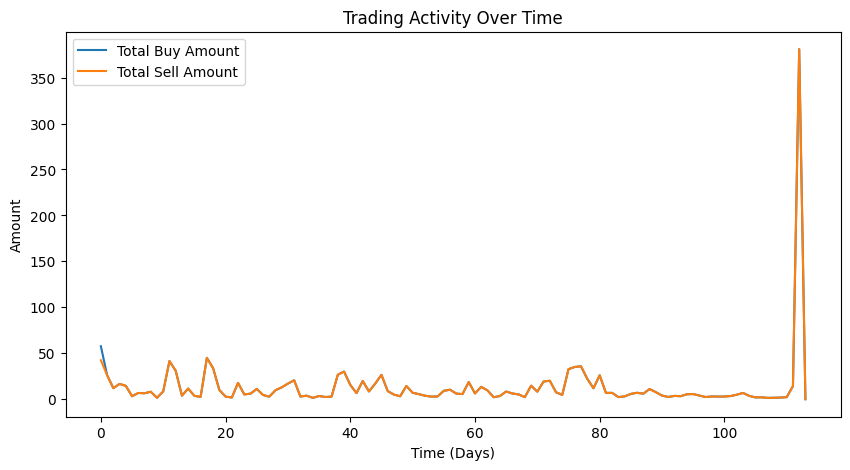

In [41]:
buy_sum = np.sum(b.value, axis=1)
sell_sum = np.sum(s.value, axis=1)

plt.figure(figsize=(10, 5))
plt.plot(buy_sum, label='Total Buy Amount')
plt.plot(sell_sum, label='Total Sell Amount')
plt.xlabel('Time (Days)')
plt.ylabel('Amount')
plt.title('Trading Activity Over Time')
plt.legend()
plt.show()

In [ ]:
test_returns_df.iloc[0].to_numpy()

array([ 0.02059553, -0.00209205,  0.01748688,  0.01916933, -0.01133144])

In [ ]:
# Variable initializations
n_stocks = 5
T = len(test_returns_df)
current_day = test_trading_days[0]
initial_cash = 10000
current_cash = initial_cash
np.random.seed(42)
#alpha = 0.1
#target_return = 0.006
#smoothing_factor = 0.1
infeasible = False

alpha_values = [0.1, 0.3, 0.5, 0.7]
target_return_values = [0.00001, 0.00005, 0.0001, 0.0002, 0.0004, 0.0005]

results = []


for alpha, target_return in itertools.product(alpha_values, target_return_values):
    print(f"Testing alpha={alpha}, target_return={target_return}")

    n_stocks = 5
    current_day = test_trading_days[0]
    initial_cash = 10000
    current_cash = initial_cash
    expected_returns_matrix_np = expected_returns_matrix.to_numpy().flatten()
    covariance_matrix_np = covariance_matrix.to_numpy()

    portfolio_value_history = []
    allocation_history = []
    daily_return_history = []


    for day in range(T):
        # Decision variable: Allocation to each stock (x_i)
        x = cp.Variable(n_stocks)

        # Objective: Minimize portfolio variance
        objective = cp.Minimize(cp.quad_form(x, covariance_matrix_np))

        # Constraints
        constraints = [
            cp.sum(x) <= 1,  # Do not have to be fully invested (sum of allocations equals 1)
            x >= 0,           # No short-selling (allocations are non-negative)
            expected_returns_matrix_np @ x >= target_return       # Target return
        ]

        # Solve the problem
        problem = cp.Problem(objective, constraints)
        problem.solve()

        # Check if the problem is infeasible
        if problem.status != cp.OPTIMAL:
            print(f"Problem is infeasible for day {day+1}")
            infeasible = True
            break

        # Optimal allocations
        weights = np.array(x.value).flatten()  # Optimal weights
        allocation_history.append(weights)
        formatted_weights = [f"{w * 100:.4f}%" for w in weights]

        print(f"Day {day+1}")
        print(f"            Weights: {formatted_weights}")

        # Compute portfolio return for the day
        daily_returns = test_returns_df.iloc[day].to_numpy()  # Daily returns
        portfolio_return = np.sum(weights * daily_returns)
        formatted_daily_returns = [f"{r:.4f}" for r in daily_returns]
        formatted_expected_returns = [f"{r:.4f}" for r in expected_returns_matrix_np]

        print(f"            Expected Returns: {formatted_expected_returns}")
        print(f"            Daily Returns: {formatted_daily_returns}")
        print(f"            Portfolio Return: {portfolio_return}")

        # Update portfolio value
        current_cash *= (1 + portfolio_return)
        print(f"            Current Cash: {current_cash}")
        portfolio_value_history.append(current_cash)
        daily_return_history.append(portfolio_return)

        # Compute portfolio variance (risk)
        portfolio_variance = weights.T @ covariance_matrix_np @ weights
        final_portfolio_variance = portfolio_variance

        # Update the expected_returns_matrix and covariance_matrix_np according to this day's data
        new_expected_returns = test_returns_df.iloc[:day + 1].mean().to_numpy().flatten()  # Mean up to the current day
        expected_returns_matrix_np = alpha * new_expected_returns + (1 - alpha) * expected_returns_matrix_np
        #print(expected_returns_matrix)

        if day > 1:
            new_covariance_matrix = test_returns_df.iloc[:day + 1].cov().to_numpy()  # Covariance up to the current day
            covariance_matrix_np = alpha * new_covariance_matrix + (1 - alpha) * covariance_matrix_np

    # Final portfolio value
    final_portfolio_value = portfolio_value_history[-1] if portfolio_value_history else initial_cash
    cumulative_return = (final_portfolio_value / initial_cash - 1) * 100
    results.append({
        "alpha": alpha,
        "target_return": target_return,
        "final_portfolio_value": final_portfolio_value,
        "cumulative_return": cumulative_return,
        "final_portfolio_variance": final_portfolio_variance
    })
results_df = pd.DataFrame(results)

# Display results
print("\nGrid Search Results:")
print(results_df)

Testing alpha=0.1, target_return=1e-05
Day 1
            Weights: ['2.2105%', '-0.0000%', '-0.0000%', '0.0000%', '-0.0000%']
            Expected Returns: ['0.0005', '-0.0006', '-0.0000', '0.0000', '-0.0014']
            Daily Returns: ['0.0206', '-0.0021', '0.0175', '0.0192', '-0.0113']
            Portfolio Return: 0.0004552568329473657
            Current Cash: 10004.552568329475
Day 2
            Weights: ['0.4070%', '0.0856%', '0.0679%', '0.1299%', '0.0973%']
            Expected Returns: ['0.0025', '-0.0007', '0.0017', '0.0019', '-0.0024']
            Daily Returns: ['0.0018', '-0.0104', '-0.0077', '-0.0011', '-0.0196']
            Portfolio Return: -2.740893553571479e-05
            Current Cash: 10004.278354193066
Day 3
            Weights: ['0.3195%', '0.0610%', '0.0208%', '0.1150%', '0.0680%']
            Expected Returns: ['0.0033', '-0.0013', '0.0020', '0.0027', '-0.0037']
            Daily Returns: ['0.0117', '-0.0103', '0.0142', '0.0087', '-0.0136']
            Portfolio 

/usr/local/lib/python3.10/dist-packages/cvxpy/problems/problem.py:1407: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Problem is infeasible for day 38
Testing alpha=0.1, target_return=0.0001
Day 1
            Weights: ['22.1046%', '-0.0000%', '-0.0000%', '0.0000%', '-0.0000%']
            Expected Returns: ['0.0005', '-0.0006', '-0.0000', '0.0000', '-0.0014']
            Daily Returns: ['0.0206', '-0.0021', '0.0175', '0.0192', '-0.0113']
            Portfolio Return: 0.0045525683294736575
            Current Cash: 10045.525683294736
Day 2
            Weights: ['3.4089%', '-0.0000%', '0.9316%', '-0.0000%', '0.0000%']
            Expected Returns: ['0.0025', '-0.0007', '0.0017', '0.0019', '-0.0024']
            Daily Returns: ['0.0018', '-0.0104', '-0.0077', '-0.0011', '-0.0196']
            Portfolio Return: -1.0977067908439668e-05
            Current Cash: 10045.415412877135
Day 3
            Weights: ['2.7030%', '0.0000%', '0.4812%', '-0.0000%', '0.0000%']
            Expected Returns: ['0.0033', '-0.0013', '0.0020', '0.0027', '-0.0037']
            Daily Returns: ['0.0117', '-0.0103', '0.0142', '0.0

#From the above grid search: the optimal alpha, and target returns are 0.1, 0.0006

# Adding DSR

In [ ]:
import cvxpy as cp
import numpy as np

# Variable initializations
n_stocks = 5
initial_cash = 10000
current_cash = initial_cash
np.random.seed(42)
alpha = 0.9
target_return = 0.001
smoothing_factor = 0.1

# Initialize DSR variables
A_t = np.float32(0.0)
B_t = np.float32(0.0)

# Initialize expected returns and covariance matrix
expected_returns_matrix = expected_returns.to_numpy().flatten()
covariance_matrix_np = covariance_matrix.to_numpy()

portfolio_value_history = []
allocation_history = []
daily_return_history = []

for day in range(5):
    # Decision variable: Allocation to each stock (x_i)
    x = cp.Variable(n_stocks)

    # Expected Portfolio Return
    portfolio_return = expected_returns_matrix @ x

    # Portfolio Variance (Risk)
    portfolio_variance = cp.quad_form(x, covariance_matrix_np)

    # Update DSR values
    smoothed_return = (1 - smoothing_factor) * A_t + smoothing_factor * portfolio_return
    smoothed_squared_return = (1 - smoothing_factor) * B_t + smoothing_factor * (portfolio_return ** 2)

    delta_A_t = smoothed_return - A_t
    delta_B_t = smoothed_squared_return - B_t

    if B_t - (A_t ** 2) > 0:
        denom = (B_t - (A_t ** 2)) ** 1.5
        numer = B_t * delta_A_t - 0.5 * A_t * delta_B_t
        dsr_value = numer / denom
    else:
        dsr_value = 0

    # Update A_t and B_t for the next iteration
    A_t = smoothed_return
    B_t = smoothed_squared_return

    # DSR Constraint: Ensure DSR is above a threshold
    #dsr_constraint = dsr_value >= 0.00001

    # Objective: Minimize portfolio variance (risk)
    objective = cp.Minimize(portfolio_variance)

    # Constraints
    constraints = [
        cp.sum(x) <= 1,  #
        x >= 0,  # No short-selling
        expected_returns_matrix @ x >= target_return       # Target return
    ]

    # Solve the problem
    problem = cp.Problem(objective, constraints)
    problem.solve()

    # Optimal allocations
    optimal_weights = x.value
    portfolio_variance = x.value.T @ covariance_matrix_np @ x.value
    portfolio_expected_return = expected_returns_matrix @ x.value
    print(x.value)
    print(dsr_value)

    print(f"Day {day + 1}")
    print(f"    Portfolio Variance (Risk): {portfolio_variance:.6f}")
    print(f"    Expected Portfolio Return: {portfolio_expected_return:.4%}")
    print(f"    Portfolio Downside Sharpe Ratio (DSR): {dsr_value:.4f}")

    # Update portfolio value
    current_cash *= (1 + portfolio_return)
    portfolio_value_history.append(current_cash)
    daily_return_history.append(portfolio_return)

    # Update expected_returns_matrix and covariance_matrix_np
    new_expected_returns = test_returns_df.iloc[:day + 1].mean().to_numpy().flatten()  # Mean up to the current day
    expected_returns_matrix = alpha * new_expected_returns + (1 - alpha) * expected_returns_matrix

    if day > 1:
        new_covariance_matrix = test_returns_df.iloc[:day + 1].cov().to_numpy()  # Covariance up to the current day
        covariance_matrix_np = alpha * new_covariance_matrix + (1 - alpha) * covariance_matrix_np

# Final portfolio value
final_portfolio_value = portfolio_value_history[-1]

# Results
print(f"Initial Portfolio Value: ${initial_cash:.2f}")
print(f"Final Portfolio Value: ${final_portfolio_value:.2f}")
print(f"Cumulative Return: {(final_portfolio_value / initial_cash - 1) * 100:.2f}%")


AttributeError: 'AddExpression' object has no attribute 'to_numpy'

In [ ]:
print(f"A_t: {A_t}, B_t: {B_t}, Portfolio Return: {portfolio_return}")
print(f"Delta A_t: {delta_A_t}, Delta B_t: {delta_B_t}, DSR Value: {dsr_value}")


A_t: 0.1 @ [ 0.00713149 -0.00040117  0.00083679 -0.00067775  0.01779784] @ var520014, B_t: 0.1 @ power([ 0.00713149 -0.00040117  0.00083679 -0.00067775  0.01779784] @ var520014, 2.0), Portfolio Return: [ 0.00713149 -0.00040117  0.00083679 -0.00067775  0.01779784] @ var520014
Delta A_t: 0.1 @ [ 0.00713149 -0.00040117  0.00083679 -0.00067775  0.01779784] @ var520014 + -0.0, Delta B_t: 0.1 @ power([ 0.00713149 -0.00040117  0.00083679 -0.00067775  0.01779784] @ var520014, 2.0) + -0.0, DSR Value: 0


In [ ]:
'''
# Solve the quadratic programming problem using PuLP library
#quadratic optimization - convax optimization - cvxpy, there is an example for PM
#https://colab.research.google.com/github/cvxgrp/cvx_short_course/blob/master/book/docs/applications/notebooks/portfolio_optimization.ipynb
#maximize return minus risk
#multistage
#https://docs.mosek.com/portfolio-cookbook/markowitz.html

# Data
n_stocks = 5
price = []

# Initialize the model and decision variables
lp_model = pulp.LpProblem("Portfolio_Optimization", pulp.LpMaximize)
x_vars = [pulp.LpVariable('x_'+str(i+1), lowBound=0, upBound=1) for i in range(n_stocks)]

# Objective Function: Maximize the return
lp_model += pulp.lpSum([price[i] * x_vars[i] for i in range(n_stocks)])

# Constraint: Similar to softmax, we have to make sure the sum of all x equal 1
lp_model += pulp.lpSum(x_vars) == 1

# Solve the model
lp_model.solve()

# Print the result
for i in range(n_stocks):
  print("Calculated weight of this stock is:", pulp.value(x_vars[i]))

print("Optimal return:", pulp.value(lp_model.objective))
'''